# medsrtqc

[![Check](https://github.com/ArgoCanada/medsrtqc/actions/workflows/check.yaml/badge.svg)](https://github.com/ArgoCanada/medsrtqc/actions/workflows/check.yaml)
[![Codecov test coverage](https://codecov.io/gh/ArgoCanada/medsrtqc/branch/master/graph/badge.svg)](https://codecov.io/gh/ArgoCanada/medsrtqc?branch=master)

A possible container for MEDS real-time quality control code.

## Installation

You can install the `medsrtqc` package using `pip`.

``` bash
pip install git+https://github.com/ArgoCanada/medsrtqc.git
```

## Examples

QC code in `medsrtqc` is built on the `Trace`, `Profile`, and `ProfileList` classes. A `Profile` is roughly what you would get from a single-cycle Argo NetCDF file; a `ProfileList` is a container of these objects. Both can be subclassed to abstract away the storage details such that QC code can be tested on NetCDF files but run with an arbitrary storage backend. You can get started with the NetCDF backend in a few lines:

In [5]:
from medsrtqc.nc import read_nc_profile
url = 'https://data-argo.ifremer.fr/dac/coriolis/6904117/profiles/R6904117_085.nc'
profile = read_nc_profile(url)
profile['TEMP']

Trace(
    value=[13.3847, 12.9791, 12.3505, [194 values], 7.2176, 7.2166, 7.2168],
    value_qc=[b'1', b'1', b'1', [194 values], b'1', b'1', b'1'],
    adjusted=[nan, nan, nan, [194 values], nan, nan, nan],
    adjusted_error=[nan, nan, nan, [194 values], nan, nan, nan],
    pres=[5.27, 5.79, 6.48, [194 values], 201.5, 202.54, 203.5],
    mtime=[nan, nan, nan, [194 values], nan, nan, nan]
)

You can specify multiple files to combine e.g. a core and a BGC file that represent the same `Profile` but are split into two files for historical and logistical reasons.

In [6]:
import re
url_bgc = re.sub(r'/R', '/BR', url)
profile = read_nc_profile(url, url_bgc)
print(repr(profile['CHLA']))
print(repr(profile['TEMP']))

Trace(
    value=[1.5622, 1.533, 1.533, [1267 values], 0.3577, 0.365, 0.3504],
    value_qc=[b'2', b'2', b'2', [1267 values], b'2', b'2', b'2'],
    adjusted=[0.7811, 0.7665, 0.7665, [1267 values], 0.17885, 0.1825, 0.1752],
    adjusted_error=[nan, nan, nan, [1267 values], nan, nan, nan],
    pres=[0.3, 0.3, 0.3, [1267 values], 204.1, 204.0, 204.0],
    mtime=[0.007025253235042328, 0.006909512492711656, 0.006793771754018962, [1267 values], -0.05231502454262227, -0.05243076528495294, -0.05254650602728361]
)
Trace(
    value=[13.3847, 12.9791, 12.3505, [194 values], 7.2176, 7.2166, 7.2168],
    value_qc=[b'1', b'1', b'1', [194 values], b'1', b'1', b'1'],
    adjusted=[nan, nan, nan, [194 values], nan, nan, nan],
    adjusted_error=[nan, nan, nan, [194 values], nan, nan, nan],
    pres=[5.27, 5.79, 6.48, [194 values], 201.5, 202.54, 203.5],
    mtime=[nan, nan, nan, [194 values], nan, nan, nan]
)


In [7]:
import matplotlib.pyplot as plt
from medsrtqc.interactive import plot

<Figure size 432x288 with 0 Axes>

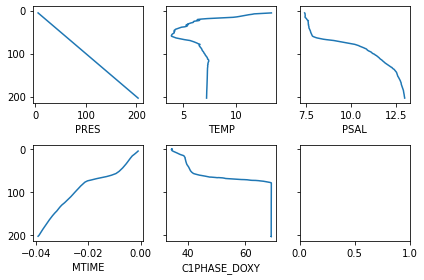

In [9]:
fig, axs = plot(profile, vars=list(profile.keys())[:6])

In [9]:
list(profile.keys())[:5]

['PRES', 'TEMP', 'PSAL', 'MTIME', 'C1PHASE_DOXY']

<AxesSubplot:>

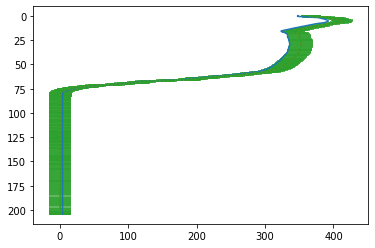

In [4]:
plot(profile['DOXY'])

In [9]:
trace = profile['TEMP']

In [17]:
value_min, value_max = np.nanmin(trace.value), np.nanmax(trace.value)
err = trace.adjusted_error.copy()
err[err.mask] = 0
adj_min, adj_max = np.nanmin(trace.adjusted - err), np.nanmax(trace.adjusted + err)

glob_min, glob_max = min([value_min, adj_min]), max([value_max, adj_min])
pres_min, pres_max = np.nanmin(trace.pres), np.nanmax(trace.pres)

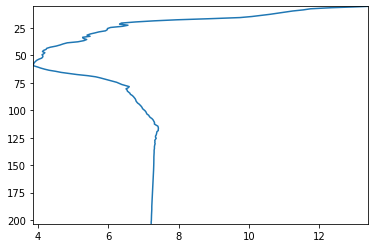

In [38]:
ax = plt.axes()
ax.plot(trace.value, trace.pres)

if np.any(~trace.adjusted.mask):
    adj = trace.adjusted.copy()
    adj[adj.mask] = np.nan
    ax.plot(adj, trace.pres, ls=':')
    ax.errorbar(adj, trace.pres, err)

ax.set_xlim((glob_min, glob_max))
ax.set_ylim((pres_max, pres_min))
plt.show()


In [37]:
trace.pres

masked_array(data=[5.269999980926514, 5.789999961853027,
                   6.480000019073486, 7.480000019073486,
                   8.489999771118164, 9.5, 10.5600004196167,
                   11.529999732971191, 12.520000457763672, 13.5,
                   14.529999732971191, 15.489999771118164,
                   16.479999542236328, 17.520000457763672,
                   18.469999313354492, 19.469999313354492,
                   20.510000228881836, 21.469999313354492,
                   22.469999313354492, 23.450000762939453,
                   24.510000228881836, 25.5, 26.440000534057617,
                   27.56999969482422, 28.540000915527344, 29.5,
                   30.40999984741211, 31.510000228881836,
                   32.560001373291016, 33.459999084472656,
                   34.470001220703125, 35.4900016784668, 36.5,
                   37.58000183105469, 38.5099983215332, 39.4900016784668,
                   40.45000076293945, 41.47999954223633, 42.5099983215332,
       

In [2]:
from medsrtqc.core import Trace, Profile
from medsrtqc.interactive import plot
import matplotlib.pyplot as plt

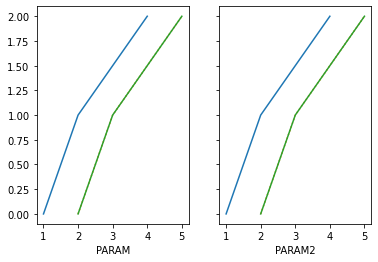

In [4]:
trace = Trace([1.0, 2.0, 4.0], adjusted=[2.0, 3.0, 5.0], pres=[0, 1, 2])
# fig, axs = plt.subplots(1, 2, sharey=True)
profile = Profile({'PARAM': trace, 'PARAM2': trace})
fig, axs = plot(profile)

In [10]:
import numpy as np

In [11]:
np.ceil(np.sqrt(5))

3.0